In [36]:
from genomic_embeddings import Embeddings

In [37]:
model_path = "/home/toibazd/Data/outputs/G2V/G2V_2024-03-14.w2v"
gene_embeddings = Embeddings.load_embeddings(model_path)

In [38]:
import json
with open("/home/toibazd/Most_frequent_IPs.json", "r") as f:
    ips = json.load(f)

sorted_dict = sorted(ips.items(), key=lambda x: x[1], reverse=True)
most_frequent_ips = [item[0] for item in sorted_dict[100:300]]


In [39]:
import pandas as pd


from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import csv
from tqdm.auto import tqdm
import numpy as np

data_dict = defaultdict(list)
ip_to_go = defaultdict(list)
enc = MultiLabelBinarizer()


new_tsv_filename = "/home/toibazd/Family_IPs_with_GO.tsv"


with open(new_tsv_filename, "r") as new_tsvfile:
    reader = csv.reader(new_tsvfile, delimiter="\t")
    next(reader)
    for row in tqdm(reader):
        ip = row[0]  # Assuming the IP is in the first column
        go_terms = row[6]  # Assuming the GO terms are in the second column

        # Add IP and corresponding GO terms to data_dict
        ip_to_go[ip]+= go_terms.split(',')

with open("/home/toibazd/Prot2IP_GO_filtered_MF.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])
        
        # Filter InterPro IDs that are in the words list
#         filtered_iprs = [ipr for ipr in iprs if ipr in most_frequent_ips]

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in most_frequent_ips and ip_to_go[ip]:
                for GO in ip_to_go[ip]:
                    data_dict[key].append(GO)



# Convert dictionary to DataFrame
df = pd.DataFrame(data_dict.items(), columns=["protein_name", "GO"])

print(df)





0it [00:00, ?it/s]

0it [00:00, ?it/s]

       protein_name                                                GO
0      WP_000081439                          [GO:0003700, GO:0006355]
1      WP_002963987                          [GO:0016853, GO:0005975]
2      WP_011161944                          [GO:0008236, GO:0006508]
3      WP_012093980                          [GO:0009002, GO:0006508]
4              4749  [GO:0005525, GO:0015093, GO:0006826, GO:0016020]
...             ...                                               ...
29052  WP_239633266                          [GO:0003700, GO:0006355]
29053  WP_257890612                          [GO:0016491, GO:0006520]
29054  WP_249589618                          [GO:0003700, GO:0006355]
29055  WP_245144403                          [GO:0003700, GO:0006355]
29056  WP_003783447                          [GO:0004637, GO:0009113]

[29057 rows x 2 columns]


In [40]:
all_values = [value for values in data_dict.values() for value in values]

# Convert the list into a set to remove duplicates
unique_go = set(all_values)

print("Number of unique words:", len(unique_go))

Number of unique words: 271


In [41]:
df['embeddings'] = pd.Series(dtype=object)

def your_embedding_function(ko):
    return gene_embeddings.wv[ko]

# Apply the embedding function to fill the 'embeddings' column
df['embeddings'] = df['protein_name'].apply(lambda ko: your_embedding_function(ko) if ko in gene_embeddings.wv else None)
df = df.dropna()
# df = df.drop(columns=["Unnamed: 0"])

In [42]:
print(df)

       protein_name                                                GO   
0      WP_000081439                          [GO:0003700, GO:0006355]  \
1      WP_002963987                          [GO:0016853, GO:0005975]   
2      WP_011161944                          [GO:0008236, GO:0006508]   
3      WP_012093980                          [GO:0009002, GO:0006508]   
4              4749  [GO:0005525, GO:0015093, GO:0006826, GO:0016020]   
...             ...                                               ...   
29052  WP_239633266                          [GO:0003700, GO:0006355]   
29053  WP_257890612                          [GO:0016491, GO:0006520]   
29054  WP_249589618                          [GO:0003700, GO:0006355]   
29055  WP_245144403                          [GO:0003700, GO:0006355]   
29056  WP_003783447                          [GO:0004637, GO:0009113]   

                                              embeddings  
0      [0.00064908667, 0.00061103195, 0.0005686064, -...  
1    

In [43]:
df.to_csv("IPs_with_labels_for_W2V.csv", index = False)

In [273]:
from sklearn.preprocessing import MultiLabelBinarizer


# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'GO' column
one_hot_encoded = mlb.fit_transform(df['GO'])

In [274]:
one_hot_encoded.shape

(29055, 271)

In [275]:
embeddings = np.array(df['embeddings'].to_list())

In [276]:
embeddings.shape

(29055, 256)

In [285]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [sum(class_counts)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(one_hot_encoded).sum(axis=0)
print(class_counts)
pos_weights = calculate_pos_weights(class_counts) 
pos_weights

[ 141  169  128  279  104   97  342  357  324 1050  579 3080  777  101
  364   36  115  666   51  181  167  162  111   95   88  128   48   19
  112  175   82   45  171  317   56   65  231  169   37   13  119  501
   94  141  101  130  106   58   98   74   58   51  102  141  190  182
   97  138   95   85   17  302  191   90  692 1058  384  305  364  426
  503   58   40   82   31   24   24  168   13   82   56   74   88  112
   34  508  167  352  103  171  328  190 2333  194  121   58  364   36
   50  182   97  138   95   85  670   95   48   19  177   27  178  141
   26 1009   84   90  191   79  137  280  384  171  194  121   89   17
  203  389  579   79  118  205  137   30  363  111   30   16  100   31
   56  124   66  253  147    2   26   45   98  168   79  115   82  169
  302  149   95   66  342   17   40   51  223  165  109    5   74  145
  137  169  228  357   54  960   82  145   82  131  165 6961  101   26
  187  200 1131  124   91  121  501   40   82  135  363  108 1588  120
   81 

tensor([4.7400e+02, 3.9600e+02, 5.2300e+02, 2.3900e+02, 6.4400e+02, 6.9000e+02,
        1.9500e+02, 1.8600e+02, 2.0600e+02, 6.2000e+01, 1.1400e+02, 2.0000e+01,
        8.5000e+01, 6.6300e+02, 1.8300e+02, 1.8630e+03, 5.8200e+02, 9.9000e+01,
        1.3140e+03, 3.6900e+02, 4.0000e+02, 4.1300e+02, 6.0300e+02, 7.0500e+02,
        7.6100e+02, 5.2300e+02, 1.3970e+03, 3.5310e+03, 5.9800e+02, 3.8200e+02,
        8.1700e+02, 1.4900e+03, 3.9100e+02, 2.1000e+02, 1.1970e+03, 1.0310e+03,
        2.8900e+02, 3.9600e+02, 1.8120e+03, 5.1610e+03, 5.6200e+02, 1.3200e+02,
        7.1200e+02, 4.7400e+02, 6.6300e+02, 5.1500e+02, 6.3200e+02, 1.1560e+03,
        6.8300e+02, 9.0500e+02, 1.1560e+03, 1.3140e+03, 6.5600e+02, 4.7400e+02,
        3.5200e+02, 3.6700e+02, 6.9000e+02, 4.8500e+02, 7.0500e+02, 7.8800e+02,
        3.9460e+03, 2.2100e+02, 3.5000e+02, 7.4400e+02, 9.5000e+01, 6.2000e+01,
        1.7300e+02, 2.1900e+02, 1.8300e+02, 1.5600e+02, 1.3200e+02, 1.1560e+03,
        1.6760e+03, 8.1700e+02, 2.1640e+

In [286]:
len(embeddings)

29055

In [287]:
# import random


# # Zip the lists together
# combined = list(zip(embeddings, one_hot_encoded))

# # Shuffle the combined list
# random.shuffle(combined)

# # Unzip the shuffled list
# embeddings, labels = zip(*combined)



In [288]:
import torch
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        return self.fc4(self.dropout(self.relu(self.fc3(self.dropout(self.relu(self.fc2(self.dropout(self.relu(self.fc1(x))))))))))

input_dim = 256
first_hidden = 256
second_hidden = 128
last_hidden = 64
output_dim = 271
dropout_prob = 0.2

model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [289]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.05)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [290]:
import numpy as np

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, one_hot_encoded, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors
        batch_embeddings_tensor = torch.tensor(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        batch_labels_tensor = batch_labels_tensor.squeeze()

        
        outputs = model(batch_embeddings_tensor)

        
        loss = criterion(outputs, batch_labels_tensor)

        
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")


Epoch 1/20:


Training Batches: 0it [00:00, ?it/s]

2.275848085124118
Epoch 2/20:


Training Batches: 0it [00:00, ?it/s]

2.2071675755033557
Epoch 3/20:


Training Batches: 0it [00:00, ?it/s]

2.0813943810726356
Epoch 4/20:


Training Batches: 0it [00:00, ?it/s]

2.057466643567628
Epoch 5/20:


Training Batches: 0it [00:00, ?it/s]

2.0470302147866115
Epoch 6/20:


Training Batches: 0it [00:00, ?it/s]

2.0421109424197845
Epoch 7/20:


Training Batches: 0it [00:00, ?it/s]

2.041905693719851
Epoch 8/20:


Training Batches: 0it [00:00, ?it/s]

2.0391180823251767
Epoch 9/20:


Training Batches: 0it [00:00, ?it/s]

2.0388700202622854
Epoch 10/20:


Training Batches: 0it [00:00, ?it/s]

2.039980314980479
Epoch 11/20:


Training Batches: 0it [00:00, ?it/s]

2.0408577932956153
Epoch 12/20:


Training Batches: 0it [00:00, ?it/s]

2.0393653986479037
Epoch 13/20:


Training Batches: 0it [00:00, ?it/s]

2.038715065959562
Epoch 14/20:


Training Batches: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [283]:
print(len(df))

29055


In [231]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [232]:
class Word2vecdataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y      
        self.len = X.shape[0] 

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
    
        X_idx = self.X[idx, :]
        y_idx = self.y[idx]
        return X_idx, y_idx

In [233]:
train_X, test_X, train_y, test_y = train_test_split(X, one_hot_encoded, test_size=0.2, random_state=42)

train_X=np.vstack(train_X)
test_X=np.vstack(test_X)


In [234]:
train_X.shape, test_X.shape

((23244, 256), (5811, 256))

In [235]:
x_train = torch.tensor(train_X, dtype=torch.float)
x_test = torch.tensor(test_X, dtype=torch.float)
y_train = torch.tensor(train_y, dtype=torch.float)
y_test = torch.tensor(test_y, dtype=torch.float)

In [236]:
train_dataset = Word2vecdataset(x_train, y_train)
test_dataset = Word2vecdataset(x_test, y_test)

batch_size = 128 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [237]:
print(y_train.shape)

torch.Size([23244, 271])


In [238]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(y_train)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(y_train).sum(axis=0)
pos_weights = calculate_pos_weights(class_counts).cuda()
print(pos_weights)

tensor([2.2037e+02, 1.6155e+02, 2.2688e+02, 1.0465e+02, 2.8955e+02, 3.2183e+02,
        8.7718e+01, 8.1134e+01, 8.4456e+01, 2.6904e+01, 4.7935e+01, 8.3801e+00,
        3.7420e+01, 2.9323e+02, 8.1719e+01, 8.9300e+02, 2.5443e+02, 4.0881e+01,
        5.2727e+02, 1.5821e+02, 1.6385e+02, 1.8202e+02, 2.5727e+02, 2.9700e+02,
        3.1741e+02, 2.2688e+02, 6.1068e+02, 1.7870e+03, 2.8596e+02, 1.6866e+02,
        3.5660e+02, 6.6311e+02, 1.7118e+02, 9.1238e+01, 4.9355e+02, 4.2162e+02,
        1.2070e+02, 1.6155e+02, 9.2876e+02, 2.1121e+03, 2.3618e+02, 5.7110e+01,
        3.0087e+02, 2.2037e+02, 2.8596e+02, 1.9938e+02, 2.7905e+02, 4.5476e+02,
        2.9323e+02, 3.9297e+02, 4.6388e+02, 5.2727e+02, 2.9700e+02, 2.1422e+02,
        1.4800e+02, 1.5821e+02, 3.1311e+02, 2.0112e+02, 3.0892e+02, 3.2638e+02,
        1.6593e+03, 9.8333e+01, 1.4427e+02, 2.9700e+02, 4.1262e+01, 2.6410e+01,
        7.5461e+01, 9.7076e+01, 8.1719e+01, 6.6570e+01, 5.7256e+01, 4.5476e+02,
        8.0052e+02, 3.8005e+02, 1.0096e+

In [241]:
import torch.optim.lr_scheduler as lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.05)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [242]:
model.train()
losses = []

for i in range(30):
    loss_epoch = 0
    print(f"Training at {i+1} epoch")
    for index, data in enumerate(train_loader):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss_epoch+=loss.item()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print("Loss: ",loss_epoch/len(train_loader), end="\n\n")
    losses.append(loss_epoch/len(train_loader))
    
print("Finished training")

Training at 1 epoch
Loss:  1.3797094697480674

Training at 2 epoch
Loss:  1.378424659535125

Training at 3 epoch
Loss:  1.3782820413400838

Training at 4 epoch
Loss:  1.378169514975705

Training at 5 epoch
Loss:  1.3780809726033891

Training at 6 epoch
Loss:  1.3749997805763077

Training at 7 epoch
Loss:  1.3749612812157517

Training at 8 epoch
Loss:  1.37492927810648

Training at 9 epoch
Loss:  1.3749022883373303

Training at 10 epoch
Loss:  1.3748792567095913

Training at 11 epoch
Loss:  1.3746964027593425

Training at 12 epoch
Loss:  1.3746953632805374

Training at 13 epoch
Loss:  1.374694334936666

Training at 14 epoch
Loss:  1.3746933052828023

Training at 15 epoch
Loss:  1.3746922821788998

Training at 16 epoch


KeyboardInterrupt: 

In [178]:
model.eval()
all_predictions = []
all_labels = []
all_probs = []

with torch.inference_mode():
    outputs = model(x_test.to(device))
    predictions = torch.sigmoid(outputs).cpu().detach().numpy()
    thresholded_predictions = (predictions > )



In [181]:
print(predictions[0])

[2.0261054e-06 3.1297157e-06 2.0775421e-06 4.8138199e-06 1.7526878e-06
 1.3090003e-06 6.2654226e-06 6.3948846e-06 6.4588844e-06 2.3809003e-05
 1.1788409e-05 8.7377011e-05 1.6524267e-05 1.5932554e-06 7.0764022e-06
 1.9075692e-03 1.9197205e-06 1.3788593e-05 1.6385674e-03 2.8654097e-06
 3.3159722e-06 2.4418589e-06 1.9825729e-06 1.6263523e-06 1.5860181e-06
 2.4151050e-06 1.2254041e-03 1.8568753e-03 2.0461348e-06 2.6660994e-06
 1.2073690e-06 1.1656964e-03 2.9545267e-06 4.9458959e-06 1.7700359e-03
 9.7162172e-07 4.2122715e-06 2.9901919e-06 1.9657512e-03 2.5735374e-03
 2.0485325e-06 9.2991177e-06 1.6897266e-06 1.9829683e-06 1.8062283e-06
 2.4816327e-06 1.8184322e-06 1.8292876e-03 1.5598248e-06 1.1292580e-06
 1.6758379e-03 1.6064500e-03 1.6504912e-06 2.4764527e-06 3.1037287e-06
 3.0004755e-06 1.1682254e-06 2.4907968e-06 1.6502410e-06 1.4538974e-06
 3.1956546e-03 5.7914062e-06 3.6536362e-06 1.4026175e-06 1.3071892e-05
 2.5484211e-05 6.3474195e-06 5.1858733e-06 6.5114978e-06 8.3731129e-06
 1.008

In [179]:
predictions.shape

(5811, 271)

In [180]:
thresholded_predictions[10]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [115]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [116]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("AUC for each column:")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

AUC for each column:
0 :  0.5545887445887445
1 :  0.4532511136227644
2 :  0.511176118609135
3 :  0.4559489993163764
4 :  0.43891480905477787
5 :  0.5073211199446941
6 :  0.5031026435177107
7 :  0.5175355327438297
8 :  0.47264482348698367
9 :  0.5025072123028458
10 :  0.5175113895216401
11 :  0.499079187631425
12 :  0.4938344667741683
13 :  0.5053235760611818
14 :  0.48234102611563573
15 :  0.5327184968108947
16 :  0.5374906399400956
17 :  0.5035253674727359
18 :  0.38495618785074337
19 :  0.4252646418678274
20 :  0.47019812512465925
21 :  0.48869459833795015
22 :  0.4524631959865121
23 :  0.4681567138419054
24 :  0.4814469749252358
25 :  0.5111029851738581
26 :  0.575418031373901
27 :  0.40645994832041343
28 :  0.4158164973769394
29 :  0.48131957296671435
30 :  0.4117037909399175
31 :  0.5219962075504223
32 :  0.5446608946608946
33 :  0.5740367881335511
34 :  0.6196139262323336
35 :  0.4356576452335804
36 :  0.460201871426096
37 :  0.45340070474037625
38 :  0.49512128527907107
39 :  0.

/home/toibazd/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/toibazd/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [117]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.3959709992239679


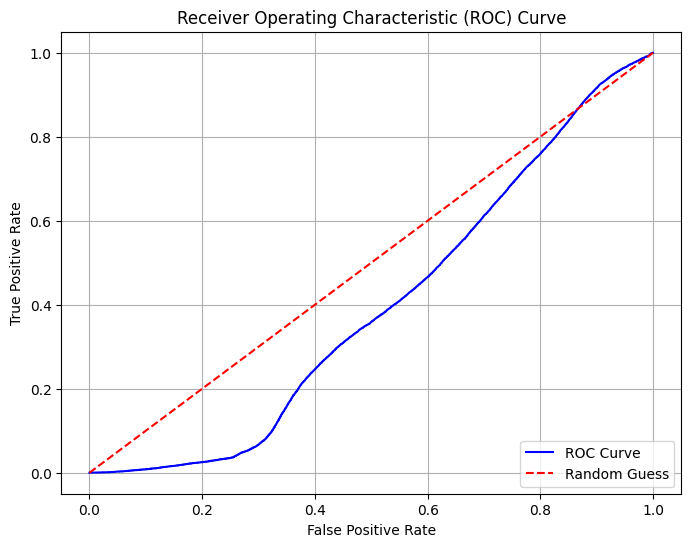

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [119]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [120]:
print(report)

              precision    recall  f1-score   support

           0        nan      0.00      0.00        36
           1        nan      0.00      0.00        26
           2        nan      0.00      0.00        26
           3        nan      0.00      0.00        59
           4        nan      0.00      0.00        24
           5        nan      0.00      0.00        25
           6        nan      0.00      0.00        80
           7        nan      0.00      0.00        74
           8        nan      0.00      0.00        52
           9        nan      0.00      0.00       217
          10        nan      0.00      0.00       104
          11        nan      0.00      0.00       602
          12        nan      0.00      0.00       172
          13        nan      0.00      0.00        22
          14        nan      0.00      0.00        83
          15        nan      0.00      0.00        10
          16        nan      0.00      0.00        24
          17        nan    

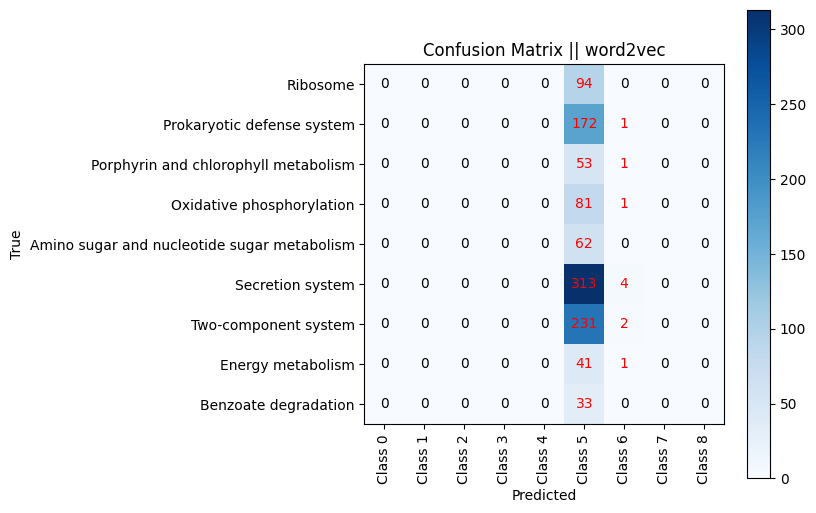

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the tensors to NumPy arrays
y_true = y_test.cpu().numpy()  # Convert to NumPy and move to CPU if using GPU
y_pred = predictions.cpu().numpy()

# Create an empty confusion matrix
confusion_matrix = np.zeros((len(label_to_int), len(label_to_int)))

# Fill in the confusion matrix
for i in range(len(y_true)):
    true_class = int(y_true[i])
    pred_class = int(y_pred[i])
    confusion_matrix[true_class, pred_class] += 1

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix || word2vec')
plt.colorbar()

tick_marks = np.arange(len(label_to_int))
plt.xticks(tick_marks, [f'Class {i}' for i in range(len(label_to_int))], rotation=90)
plt.yticks(tick_marks, list(label_to_int.keys()))

for i in range(len(label_to_int)):
    for j in range(len(label_to_int)):
        plt.text(j, i, f'{int(confusion_matrix[i, j]):d}', ha='center', va='center', color='red' if confusion_matrix[i, j] > 0.5 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("Results/Confmat_word2vec.jpg")
plt.show()



In [38]:
print(torch.sum(y_test == 0).item())
print(torch.sum(y_test == 1).item())
print(torch.sum(y_test == 2).item())
print(torch.sum(y_test == 3).item())
print(torch.sum(y_test == 4).item())
print(torch.sum(y_test == 5).item())
print(torch.sum(y_test == 6).item())
print(torch.sum(y_test == 7).item())
print(torch.sum(y_test == 8).item())

label_to_int

94
173
54
82
62
317
233
42
33


{'Ribosome': 0,
 'Prokaryotic defense system': 1,
 'Porphyrin and chlorophyll metabolism': 2,
 'Oxidative phosphorylation': 3,
 'Amino sugar and nucleotide sugar metabolism': 4,
 'Secretion system': 5,
 'Two-component system': 6,
 'Energy metabolism': 7,
 'Benzoate degradation': 8}

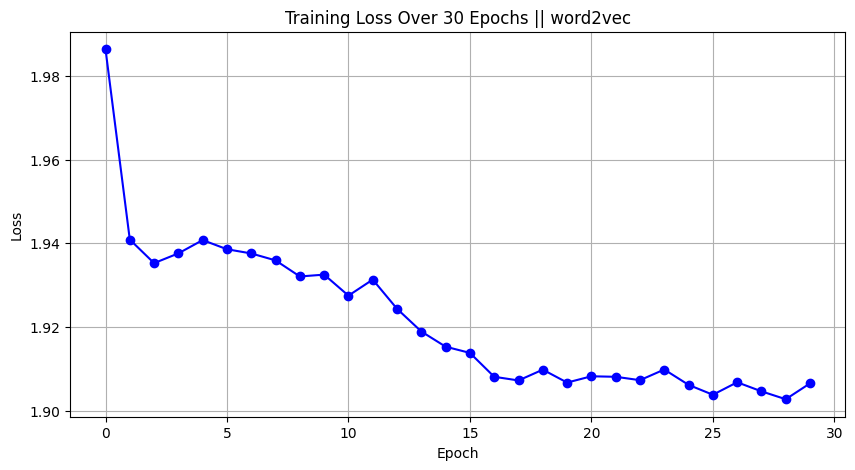

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
plt.title(f'Training Loss Over {len(losses)} Epochs || word2vec')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig("Results/Training_loss_word2vec.png")
plt.show()